In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from plotly import graph_objects as go
import plotly
import plotly.express as px
from sklearn.model_selection import train_test_split

In [2]:
plotly.offline.init_notebook_mode(connected=True)

In [3]:
data_path = "../data/data.xlsx"

In [4]:
df = pd.read_excel(data_path, skiprows=1, parse_dates=[])
df.columns = ['api_doc', 'score']
df['api_doc'] = df['api_doc'].astype(str)
df.head()

,api_doc,score
0,20.16% Off All Orders - Ring in the New Year i...,1
1,Zazzle User Agreement,1
2,Acceptance of Terms,1
3,"""Designed by [Designer]"": This label informs y...",2
4,"ZAZZLE INC. (""ZAZZLE"") PROVIDES ITS WEBSITE AN...",3


In [5]:
df.shape

(7199, 2)

In [6]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)


# Analysis

## 1. Is data balanced? 

- score distribution
- text length distribution by score

In [7]:
df = train_df.reset_index(drop=True)
df['text_len'] = df['api_doc'].str.len()

In [8]:
scores = df.score.values
scores[:5]

array([1, 5, 1, 1, 4])

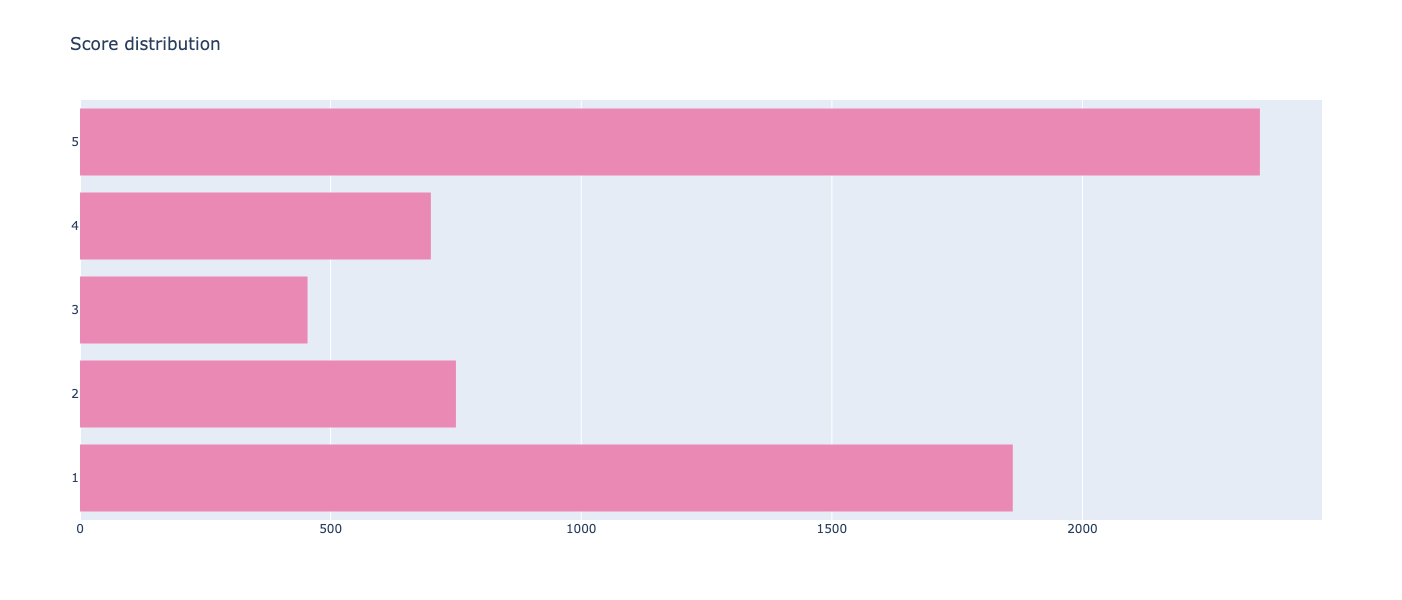

In [9]:
layout = go.Layout(
    title='Score distribution',
    bargap=0.2,
    height=600,
)

fig = go.Figure(
    data=[go.Histogram(
        y = scores,
        marker_color='#EB89B5',
    )],
    layout = layout,
)
fig.show()

Data is quite imbalanced, socre 1 and 5 get most rows
- when doing training, should solve this imbalance

In [10]:
text_lens = df.text_len

In [11]:
# Text length distribution by score

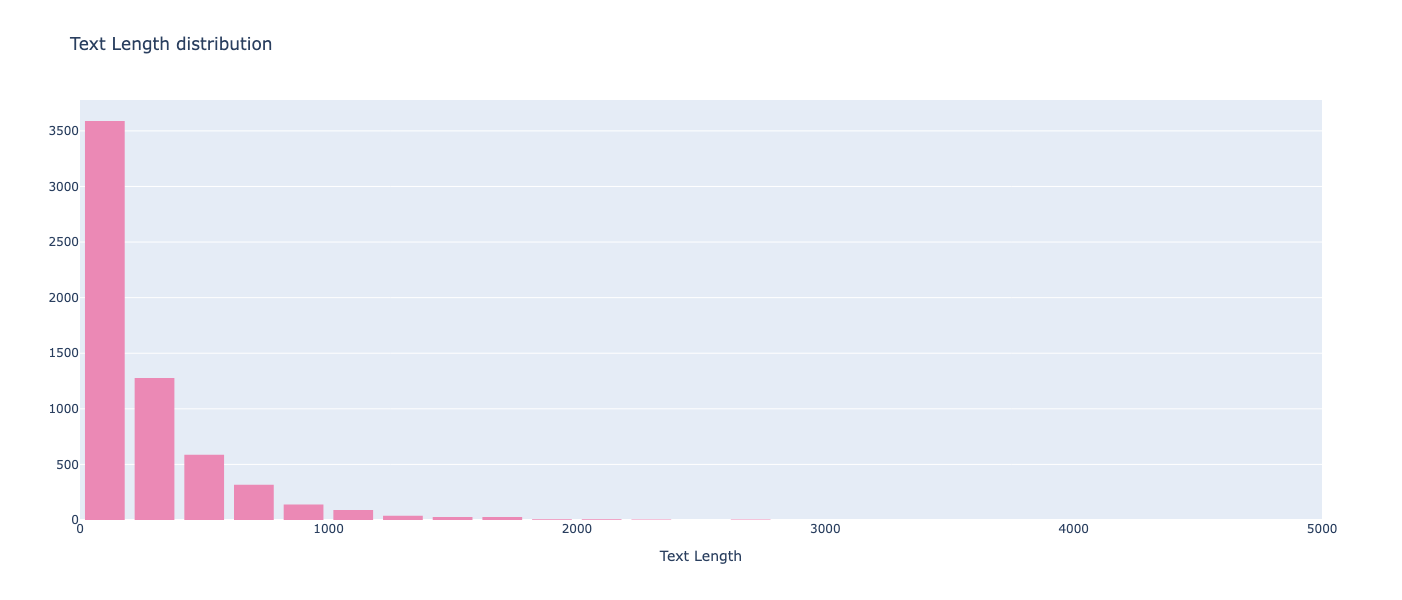

In [12]:
layout = go.Layout(
    title='Text Length distribution',
    xaxis=dict(title='Text Length'),
    # yaxis=dict(title='Count', type='log'),
    bargap=0.2,
    height=600,
)

fig = go.Figure(
    data=[go.Histogram(
        x = text_lens,
        marker_color='#EB89B5',
        nbinsx=30,
    )],
    layout = layout,
)
fig.show()

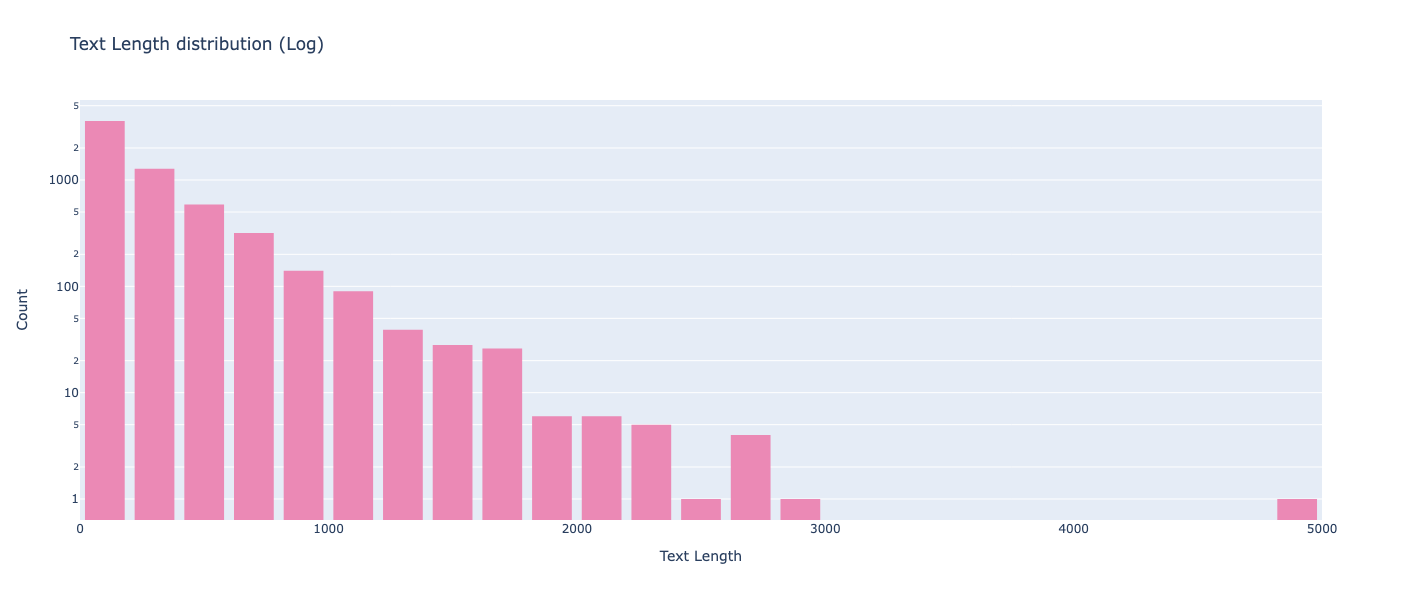

In [13]:
layout = go.Layout(
    title='Text Length distribution (Log)',
    xaxis=dict(title='Text Length'),
    yaxis=dict(title='Count', type='log'),
    bargap=0.2,
    height=600,
)

fig = go.Figure(
    data=[go.Histogram(
        x = text_lens,
        marker_color='#EB89B5',
        nbinsx=30,
    )],
    layout = layout,
)
fig.show()

In [14]:
np.mean(text_lens), np.min(text_lens), np.max(text_lens)

(251.96666121915345, 3, 4852)

In [15]:
df[df.text_len == 5][:5]

,api_doc,score,text_len
345,LINKS,1,5
514,means,2,5
751,?Term,1,5
1024,Other,1,5
1366,Usage,1,5


Does the 1-word data make sense? maybe we should remove these data, for example, why `means` have risk level == 2?

In [16]:
len(df[df.text_len == 5])

15

In [17]:
# Each score's text length distribution
df_agg = df.groupby(['score'])['text_len'].mean().reset_index()
df_agg

,score,text_len
0,1,44.941967
1,2,243.282667
2,3,276.449339
3,4,310.354286
4,5,396.316483


In [18]:
# seems longer text tend to have higher risk scores?
# Let's do a correlation calculation
# Note: score==1 might due to the outliers we need to clean up (1-word text)

df['log_text_len'] = np.log(df.text_len)

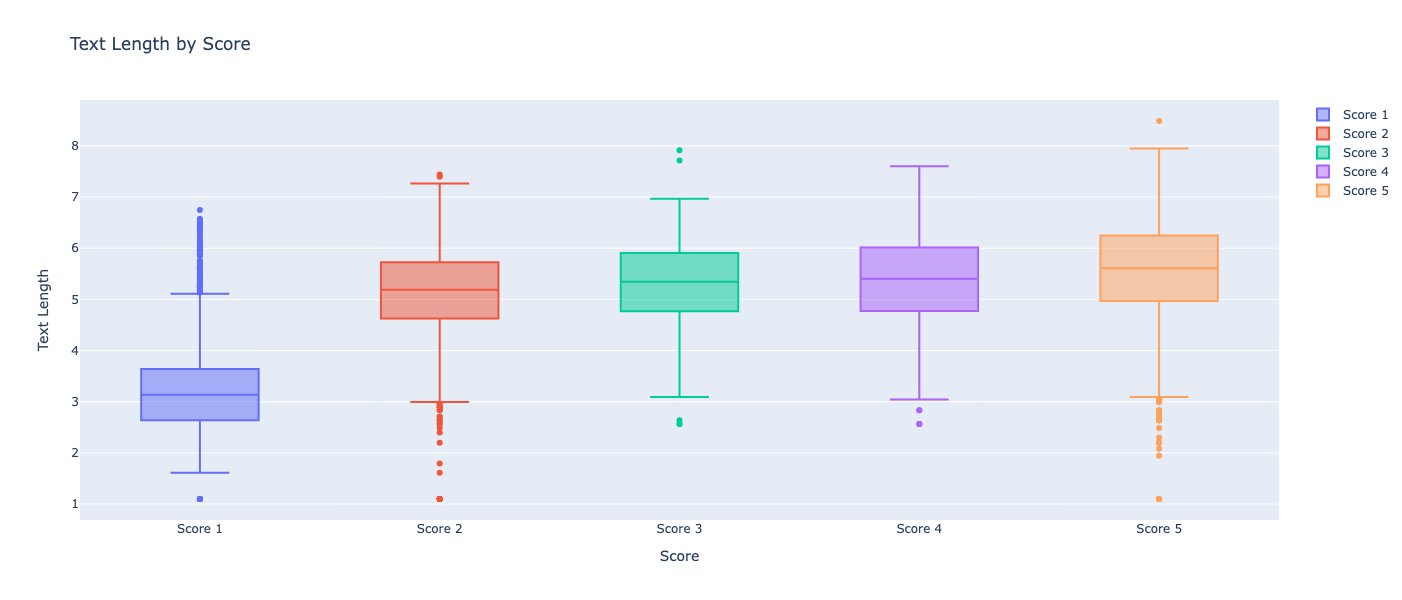

In [19]:
fig = go.Figure()

fig.update_layout(
    title='Text Length by Score',
    xaxis=dict(title='Score'),
    yaxis=dict(title='Text Length'),
    height=600,
)

for score in range(1, 6):
    _df = df[df.score == score]
    fig.add_trace(
        go.Box(
            y = _df['log_text_len'],
            name=f'Score {score}',
        )
    )
fig.show()

In [20]:
df['api_doc'].head()

0                                           Ownership.
1    If you collect personal data, you must do so s...
2                            Communication with Google
3    ? 2016 The New York Public Library. All rights...
4    The Privacy Service. If you use the Privacy Se...
Name: api_doc, dtype: object

## 2. Feature analysis
- feature word distribution
    - get tfidf feature words per doc
    - word cloud for each score
    
- use embedding to visualize each score's keywords and how they clustered, if it makes sense

In [21]:
df['api_doc'][10]

'2015-12-18 00:00:00'

In [22]:
# rough token count
# TODO: use more accurate token counts
# TODO: TFIDF?
df = df.copy()
df.loc[:, 'token_cnt'] = df['api_doc'].str.split().apply(len)

In [23]:
df = df[df['token_cnt'] > 3]

df['token_cnt'].describe()

count    5052.000000
mean       48.267815
std        51.731023
min         4.000000
25%        14.000000
50%        32.000000
75%        64.000000
max       788.000000
Name: token_cnt, dtype: float64

In [24]:
# Each score's text length distribution
df_agg = df.groupby(['score'])['token_cnt'].mean().reset_index()
df_agg

,score,token_cnt
0,1,12.434028
1,2,40.393305
2,3,44.709534
3,4,49.593660
4,5,64.300086


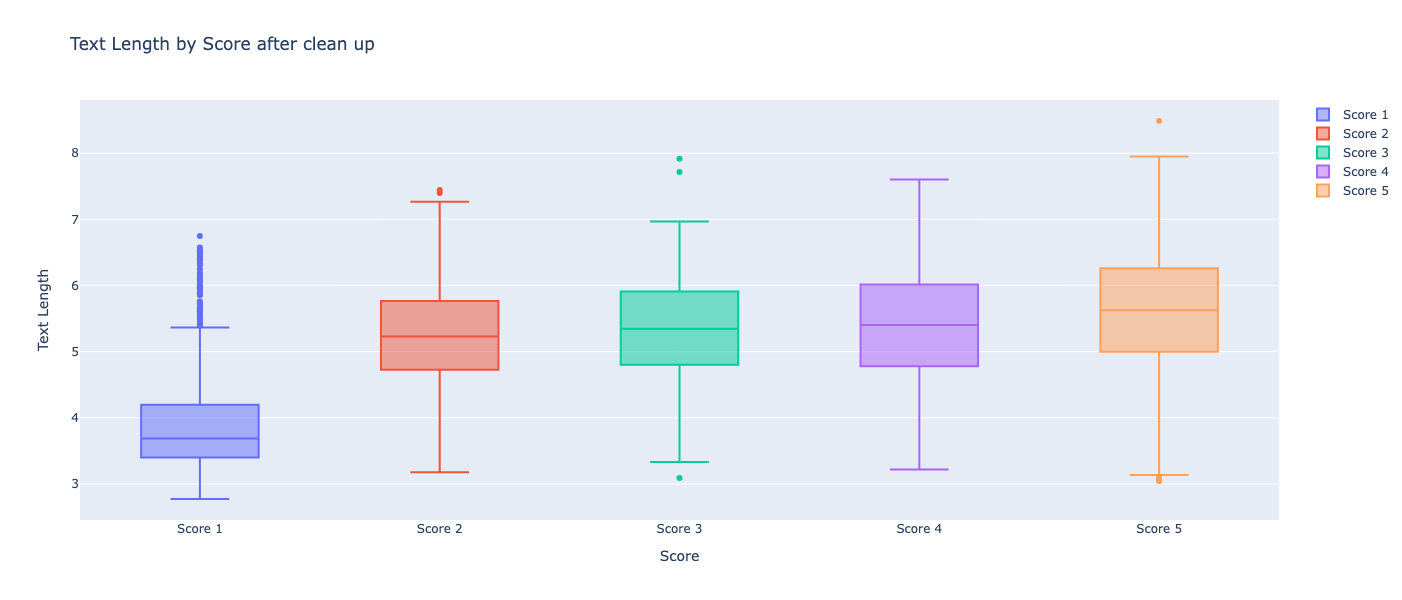

In [25]:
fig = go.Figure()

fig.update_layout(
    title='Text Length by Score after clean up',
    xaxis=dict(title='Score'),
    yaxis=dict(title='Text Length'),
    height=600,
)

for score in range(1, 6):
    _df = df[df.score == score]
    fig.add_trace(
        go.Box(
            y = _df['log_text_len'],
            name=f'Score {score}',
        )
    )
fig.show()

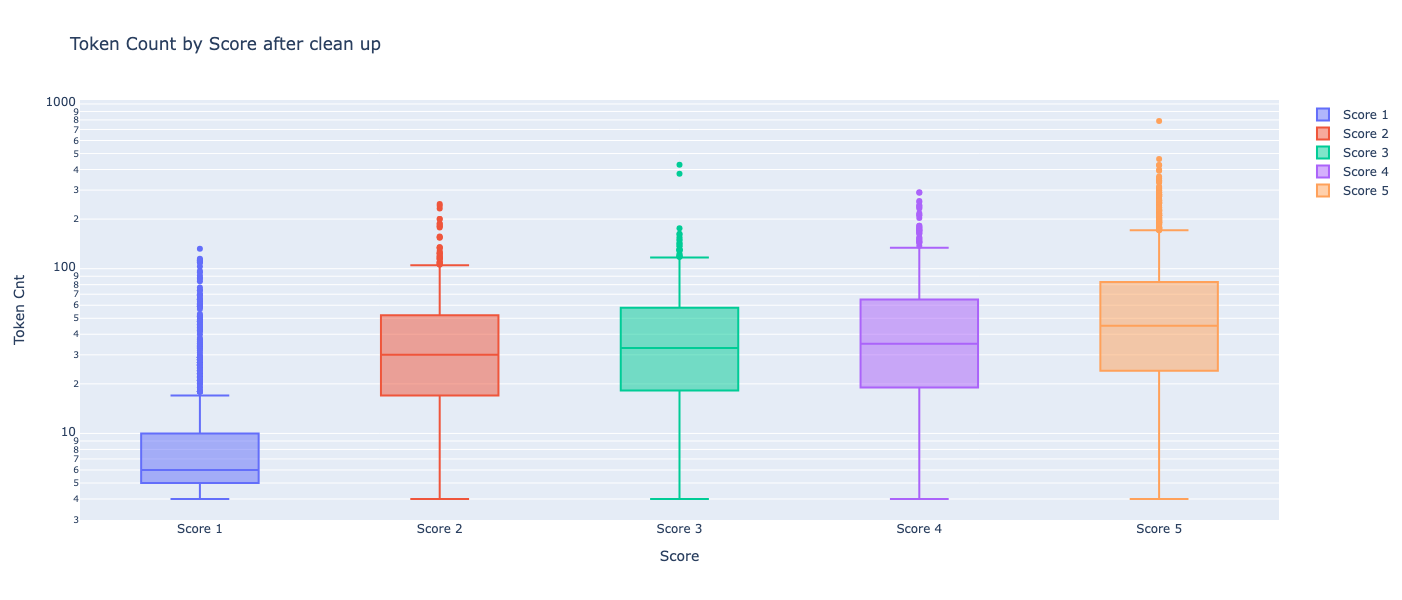

In [26]:
fig = go.Figure()

fig.update_layout(
    title='Token Count by Score after clean up',
    xaxis=dict(title='Score'),
    yaxis=dict(title='Token Cnt', type='log'),
    height=600,
)

for score in range(1, 6):
    _df = df[df.score == score]
    fig.add_trace(
        go.Box(
            y = _df['token_cnt'],
            name=f'Score {score}',
        )
    )
fig.show()

In [27]:
df[df.token_cnt == 788]

,api_doc,score,text_len,log_text_len,token_cnt
3100,S. Energy Information Administration Applicati...,5,4852,8.487146,788


In [28]:
# Use TF-IDF to extract feature words of each text

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def extract_feature_words(texts, max_features_per_document=5):
    # Initializing the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Fitting the model and transforming the data
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Getting feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Identifying feature words for each text
    top_features_per_document = []
    for row in tfidf_matrix:
        # Get the indices of the max_features_per_document largest values
        top_indices = row.toarray()[0].argsort()[-max_features_per_document:][::-1]
        top_features = feature_names[top_indices]
        top_features_per_document.append(top_features)

    return np.array(top_features_per_document)

In [31]:
features = extract_feature_words(df['api_doc'].values)

In [32]:
tf_idf_data = [{
    'score': df.score.iloc[i],
    'features': features[i],
} for i in range(len(df))]


In [33]:
tf_idf_data[:5]

[{'score': 5,
  'features': array(['securely', 'collect', 'personal', 'data', 'employment'],
        dtype=object)},
 {'score': 1,
  'features': array(['york', '2016', 'library', 'reserved', 'new'], dtype=object)},
 {'score': 4,
  'features': array(['privacy', 'following', 'authorize', 'service', 'functions'],
        dtype=object)},
 {'score': 5,
  'features': array(['managebgl', 'developer', 'platform', 'api', 'carefully'],
        dtype=object)},
 {'score': 4,
  'features': array(['client', 'statistics', 'permanently', 'profile', 'delete'],
        dtype=object)}]

In [34]:
from collections import Counter

In [35]:
counters = [Counter() for _ in range(6)]

In [36]:
for d in tf_idf_data:
    _score = d['score']
    _words = d['features']
    
    counters[_score].update(_words)

In [37]:
most_commons = [counter.most_common(10) for counter in counters]
most_commons

[[],
 [('zustaendigen', 353),
  ('employer', 103),
  ('employees', 99),
  ('emed', 85),
  ('license', 79),
  ('employment', 72),
  ('terms', 71),
  ('emergency', 64),
  ('api', 57),
  ('use', 53)],
 [('work', 49),
  ('code', 39),
  ('license', 34),
  ('program', 27),
  ('means', 24),
  ('contributor', 23),
  ('api', 23),
  ('modifications', 23),
  ('zustaendigen', 22),
  ('copyright', 22)],
 [('agreement', 29),
  ('apis', 28),
  ('linkedin', 19),
  ('yahoo', 19),
  ('site', 17),
  ('employer', 16),
  ('application', 15),
  ('zustaendigen', 15),
  ('api', 15),
  ('terms', 14)],
 [('linkedin', 62),
  ('apis', 36),
  ('application', 31),
  ('terms', 30),
  ('api', 26),
  ('content', 22),
  ('yahoo', 20),
  ('zustaendigen', 20),
  ('information', 17),
  ('google', 17)],
 [('api', 114),
  ('yahoo', 110),
  ('terms', 93),
  ('license', 81),
  ('content', 78),
  ('agreement', 77),
  ('zustaendigen', 76),
  ('google', 76),
  ('work', 72),
  ('code', 70)]]

In [38]:
from plotly.subplots import make_subplots


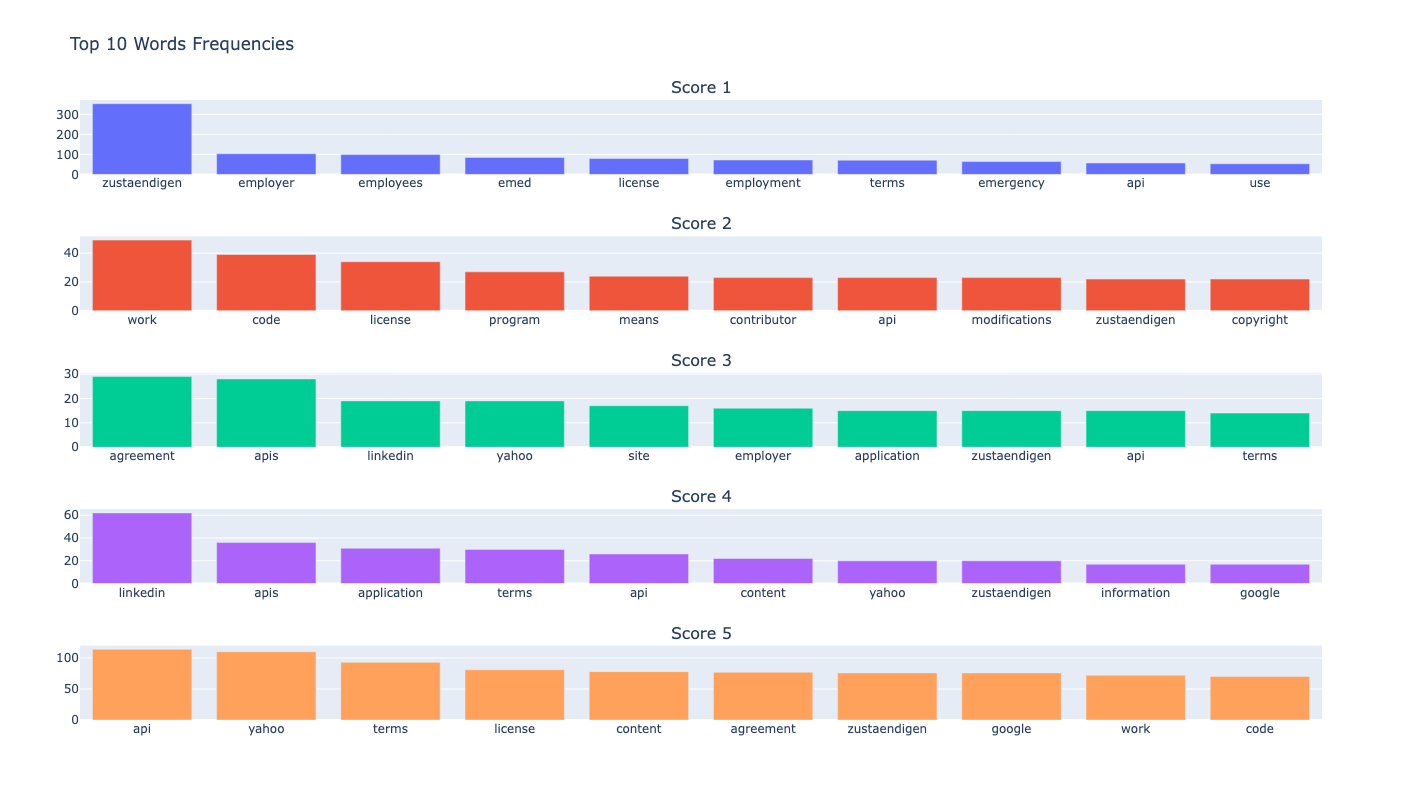

In [39]:
fig = make_subplots(rows=5, cols=1, subplot_titles=[f'Score {i}' for i in range(1, 6)])

for i, words in enumerate(most_commons[1:]):
    labels, values = zip(*words)  # Unpacking words and their counts

    fig.add_trace(
        go.Bar(x=labels, y=values, name=f'Counter {i}'),
        row=i+1, col=1
    )

fig.update_layout(
    title_text="Top 10 Words Frequencies",
    showlegend=False,
    height=800,
)

fig.show()

In [ ]:
# Seems there're a lot of overlapping of feature words
# Approach considering semantic context would be better

# Model options
- Task: Multi-classification problem
- Encoder model like BERT + 2 layer NN + softmax classifier
- prompt

# Prompt Approach


In [40]:
examples = df[['api_doc', 'score']].iloc[:100]
examples

,api_doc,score
1,"If you collect personal data, you must do so s...",5
3,? 2016 The New York Public Library. All rights...,1
4,The Privacy Service. If you use the Privacy Se...,4
5,Thank you for developing on the ManageBGL plat...,5
6,As soon as your client elects to stop receivin...,4
...,...,...
114,That data must be deleted promptly when a clie...,4
115,You will only access (or attempt to access) an...,3
116,You may only use the profile data for the bene...,4
117,? 2015 Skype and/or Microsoft.,1


In [41]:
examples = examples.values

In [42]:
examples[:5]

array([['If you collect personal data, you must do so securely', 5],
       ['? 2016 The New York Public Library. All rights reserved.', 1],
       ['The Privacy Service. If you use the Privacy Service for a Registered Name, you request that we perform the following functions and expressly authorize us to take the following actions on your behalf:',
        4],
       ['Thank you for developing on the ManageBGL platform!?By using the Developer Platform, or otherwise building or distributing a ManageBGL API App, ("Developing on ManageBGL") you agree to be bound by these ManageBGL API Terms and Conditions (the "Developer Terms"), which govern your access to and use of the ManageBGL API service, any ManageBGL developer web pages and documentation, and API SDKs, app keys, and access tokens (collectively, the "Developer Platform"). Please carefully read these API Terms before investing your time to use the Developer Platform. Please also carefully read the? ManageBGL Terms of Service ?and o

In [43]:
example_str = ""

for i, (text, score) in enumerate(examples):
    _text = f"\nExample - {i}:\n Text: {text}\nScore: {score}\n"
    example_str += _text

In [44]:
print(example_str)


Example - 0:
 Text: If you collect personal data, you must do so securely
Score: 5

Example - 1:
 Text: ? 2016 The New York Public Library. All rights reserved.
Score: 1

Example - 2:
 Text: The Privacy Service. If you use the Privacy Service for a Registered Name, you request that we perform the following functions and expressly authorize us to take the following actions on your behalf:
Score: 4

Example - 3:
 Text: Thank you for developing on the ManageBGL platform!?By using the Developer Platform, or otherwise building or distributing a ManageBGL API App, ("Developing on ManageBGL") you agree to be bound by these ManageBGL API Terms and Conditions (the "Developer Terms"), which govern your access to and use of the ManageBGL API service, any ManageBGL developer web pages and documentation, and API SDKs, app keys, and access tokens (collectively, the "Developer Platform"). Please carefully read these API Terms before investing your time to use the Developer Platform. Please also care

In [45]:
def get_sys_prompt(example_str: str):

    return f"""
    Now you are an expert of API security, you're given a task to identify risk level of a document.
    Some examples:
    {example_str}
    """

def get_user_prompt(input_str: str):
    return f"""
    Now given input:
    ```
    {input_str}
    ```
    Please output the score, wrap in JSON format:
    
    """

In [46]:
import os

In [47]:
assert 'OPENAI_API_KEY' in os.environ, "You should configure OPENAI_API_KEY to use below functions"

In [50]:
from openai import OpenAI
client = OpenAI()

In [51]:
input_str = df[['api_doc']].iloc[200].api_doc
input_str

'We endeavor to protect the privacy of your account and other Personal Information we hold in our records, but we cannot guarantee complete security. Unauthorized entry or use, hardware or software failure, and other factors, may compromise the security of user information at any time.'

In [52]:
%%time
completion = client.chat.completions.create(
  model="gpt-3.5-turbo-0125",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": get_sys_prompt(example_str)},
    {"role": "user", "content": get_user_prompt(input_str)}
  ]
)



CPU times: user 28.6 ms, sys: 17.7 ms, total: 46.3 ms
Wall time: 1.55 s


In [53]:
print(completion.choices[0].message)

ChatCompletionMessage(content='{\n    "Score": 4\n}', role='assistant', function_call=None, tool_calls=None)


In [54]:
df[['score']].iloc[200].score

2

In [55]:
test_df.shape

(1080, 2)